# Exercise 01: Exploring and Analyzing Protein Structures in the PDB Database

## Aim of the exercise

The goal of this exercise is to extract and analyse pdb files from the PDB database.

We will learn how to:

- perform queries to the pdb database
- extract pdb IDs – each structure is defined by its ID code
- extract information about structures
- perform different analyses (e.g. find  structure with lowest resolution)

partially based on [Drazen Petrov](https://orcid.org/0000-0001-6221-7369)'s Exercises and on [TeachOpenCADD](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x) and

In [3]:
# Check if running on Google Colab
try:
    from google.colab import drive

    is_google_colab = True
except ImportError:
    is_google_colab = False

# If on Google Colab, install the package
if is_google_colab:
    %pip install numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 matplotlib==3.9.2 biopandas==0.4.1 pypdb==2.4 tqdm==4.66.1 py3dmol==2.0.4

# NOTE: Ignore specific warning message from ipykernel=5.5.6
import warnings

warnings.filterwarnings(
    "ignore",
    message=r"`should_run_async`.*",
    category=DeprecationWarning,
    module=r"ipykernel\.ipkernel",
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.6
    Uninstalling tqdm-4.66.6:
      Successfully uninstalled tqdm-4.66.6
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0


In [11]:
# import needed libraries
import math

import requests
import json
import tqdm
from tqdm import tqdm

import scipy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import pypdb
import biopandas

import py3Dmol


mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.figsize"] = [5, 3]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Print versions of each library
print(f"Running on Google Colab: {is_google_colab}")
print(f"numpy=={np.__version__}")
print(f"scipy=={scipy.__version__}")
print(f"pandas=={pd.__version__}")
print(f"matplotlib=={plt.matplotlib.__version__}")
print(f"biopandas=={biopandas.__version__}")
# print(f"pypdb=={pypdb.__version__}") # NOTE: pypdb does not have a __version__ attribute
# print(f"tqdm=={tqdm.__version__}") # NOTE: tqdm does not have a __version__ attribute
print(f"py3dmol=={py3Dmol.__version__}")

Running on Google Colab: True
numpy==1.26.4
scipy==1.13.1
pandas==2.2.2
matplotlib==3.8.0
biopandas==0.4.1
py3dmol==2.0.4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## PDB Protein Data Bank

The [RCSB PDB](https://www.rcsb.org/) (Research Collaboratory for Structural Bioinformatics Protein Data Bank) is a comprehensive database for the 3D structural information of biological macromolecules. The aim of RCSB PDB is to provide open access to 3D structural data of biological macromolecules to advance research and understanding of molecular biology and biochemistry. The RCSB PDB also provides a variety of tools and resources. Users can perform simple and advanced searches based on annotations relating to sequence, structure and function. These molecules are visualized, downloaded, and analyzed by users who range from students to specialized scientists.



### Protein of interest

Today we will take a look at the human tyrosine-protein kinase. This protein is involved in cell differentiation, cell division, cell adhesion, stress response and apoptosis. It is also a target for cancer therapy.

The UNIPROT ID of this protein is P00519. You can find more information about this protein at [https://www.uniprot.org/uniprot/P00519](https://www.uniprot.org/uniprot/P00519)

To perform a search in the PDB database, copy the uniprot id (P00519) to the search box at [https://www.rcsb.org/](https://www.rcsb.org/)
Be free to explore the website and the information available for this protein.

### Programmatic access to PDB

While performing search over the website is straightforward, making repeated searches to systematically analyze structures of interest is only possible using a programmatic access.

Therefore, we will use the [PDB Search API](https://www.rcsb.org/docs/programmatic-access/web-services) to perform queries to the PDB database.

How does it work? The API lets you search the PDB database with a JSON query in a URL and retrieve results in JSON format for further extraction.

The API is well document in [https://search.rcsb.org/index.html#search-api](https://search.rcsb.org/index.html#search-api). You can find there also examples of queries [https://search.rcsb.org/index.html#examples](https://search.rcsb.org/index.html#examples).

We will use [pypdb](https://github.com/williamgilpin/pypdb) to easily access and download PDB data based on metadata like protein and ligand names.


In [8]:
# prepare search parameters using the uniprot ID of ABL1 (P00519)
search_dict = {
    "query": {
        "type": "terminal",
        "label": "full_text",
        "service": "full_text",
        "parameters": {"value": "P00519"},
    },
    "return_type": "entry",
    "request_options": {
        "paginate": {"start": 0, "rows": 10000},
        "results_content_type": ["experimental"],
        "sort": [{"sort_by": "score", "direction": "desc"}],
        "scoring_strategy": "combined",
    },
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# performing the search
response = requests.get(
    "https://search.rcsb.org/rcsbsearch/v2/query?json=" + json.dumps(search_dict)
)
data = response.json()
# printing the keys of the retreived dictionary
data.keys()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['query_id', 'result_type', 'total_count', 'result_set'])

In [10]:
# showing the total number of hits (how does this compare to the search performed on the website directly?)
data["total_count"], len(data["result_set"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(84, 84)

In [ ]:
data["result_set"][0]

{'identifier': '1AB2', 'score': 1.0}

In [ ]:
def extract_pdb_ids(search_result: dict) -> list:
    """Extracts the PDB IDs from the search result."""
    pdb_IDs = []
    for entry in search_result["result_set"]:
        pdb_IDs.append(entry["identifier"])
    return pdb_IDs


found_pdb_ids = extract_pdb_ids(data)

In [ ]:
# here we look at how many hits we got
len(found_pdb_ids)

84

In [ ]:
# here we look at the first 5 pdb codes
found_pdb_ids[:5]

['1AB2', '1AWO', '1ZZP', '2ABL', '2F4J']

### Extracting information of one protein

In [ ]:
# let's take a look at some information about one of the structures from the list (PDB ID 1BBZ)
pdb_1bbz_info = pypdb.get_info("1BBZ")
for key, value in pdb_1bbz_info.items():
    # print(key, value) # this line would print all the data available (long output)!
    print(key, end=", ")  # here we just print the keys

audit_author, cell, citation, diffrn, diffrn_detector, diffrn_radiation, diffrn_source, entry, exptl, exptl_crystal, exptl_crystal_grow, pdbx_audit_revision_category, pdbx_audit_revision_details, pdbx_audit_revision_group, pdbx_audit_revision_history, pdbx_audit_revision_item, pdbx_database_status, pdbx_initial_refinement_model, rcsb_accession_info, rcsb_entry_container_identifiers, rcsb_entry_info, rcsb_primary_citation, refine, refine_hist, refine_ls_restr, reflns, reflns_shell, software, struct, struct_keywords, symmetry, rcsb_id, 

Now, our problems is the fact that we have to much information. We are interested in parameters as resolution, method, date, number of atoms, etc.

Let's try to extract this information from the dictionary.

now try to do the same search direct on the PDB website https://www.rcsb.org/

In [ ]:
# let's extract some of the (interesting) information
# of course, what is interesting depends on the project you are involved in
# this is one example of such a function
def extract_interesting_info(pdb_info: dict) -> dict:
    """Extracts interesting information from the PDB info."""
    info = {
        "pdb_id": pdb_info["rcsb_id"],
        "desc": pdb_info["struct"].get("pdbx_descriptor"),
        "title": pdb_info["struct"]["title"],
        "method": pdb_info["exptl"][0]["method"],
        "date": pdb_info["rcsb_accession_info"]["deposit_date"],
        "num_atoms": pdb_info["rcsb_entry_info"]["deposited_atom_count"],
        "resolution": None,
        "rwork": None,
        "rfree": None,
    }

    # only for X-ray
    try:
        xray_info = {
            "resolution": pdb_info["refine"][0]["ls_dres_high"],
            "rwork": pdb_info["refine"][0]["ls_rfactor_rwork"],
            "rfree": pdb_info["refine"][0]["ls_rfactor_rfree"],
        }
        info.update(xray_info)
    except Exception as e:
        # print(f"Error: {e}")
        pass

    return (
        info  # pdb_id, desc, title, method, date, num_atoms, resolution, rwork, rfree
    )

In [ ]:
extract_interesting_info(pdb_1bbz_info)

{'pdb_id': '1BBZ',
 'desc': None,
 'title': 'CRYSTAL STRUCTURE OF THE ABL-SH3 DOMAIN COMPLEXED WITH A DESIGNED HIGH-AFFINITY PEPTIDE LIGAND: IMPLICATIONS FOR SH3-LIGAND INTERACTIONS',
 'method': 'X-RAY DIFFRACTION',
 'date': '1998-04-28T00:00:00+0000',
 'num_atoms': 2415,
 'resolution': 1.65,
 'rwork': 0.205,
 'rfree': 0.266}

### Extracting information of the found proteins

We will use the function defined `extract_interesting_info` to extract the information of each protein.

In [ ]:
# let’s collect data for all retrieved pdb codes
pdb_data = []
for pdb_id in tqdm(found_pdb_ids):
    pdb_data.append(extract_interesting_info(pypdb.get_info(pdb_id)))

100%|██████████| 84/84 [00:06<00:00, 13.39it/s]


In [21]:
# now we store this data in a pandas dataframe
pdbs = pd.DataFrame(pdb_data)
pdbs.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pdb_id,desc,title,method,date,num_atoms,resolution,rwork,rfree
0,2AYA,None,Solution Structure of the C-Terminal 14 kDa Do...,SOLUTION NMR,2005-09-07T00:00:00+0000,1007,NaN,NaN,NaN
1,1NJG,None,Nucleotide-free form of an Isolated E. coli Cl...,X-RAY DIFFRACTION,2002-12-30T00:00:00+0000,3862,2.2,0.2380,0.2680
2,1NJF,None,Nucleotide bound form of an isolated E. coli c...,X-RAY DIFFRACTION,2002-12-30T00:00:00+0000,7862,2.3,0.2100,0.2480
3,1JR3,None,Crystal Structure of the Processivity Clamp Lo...,X-RAY DIFFRACTION,2001-08-10T00:00:00+0000,13845,2.7,0.2676,0.3043
4,8GJ3,None,E. coli clamp loader on primed template DNA,ELECTRON MICROSCOPY,2023-03-14T00:00:00+0000,14894,NaN,NaN,NaN


#### Let's make some plots

looking at the release years and resolution of the structures

In [ ]:
# a little bit of preprocessing
# let's convert the date column to datetime format
pdbs["date"] = pd.to_datetime(pdbs["date"])
pdbs["year"] = pdbs["date"].dt.year

<Axes: xlabel='date'>

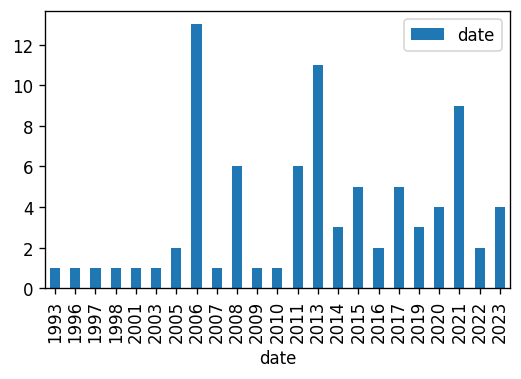

In [ ]:
df = pdbs
df[["date"]].groupby(df["date"].dt.year).count().plot(kind="bar")

In [ ]:
structures_per_year = pdbs["year"].value_counts().reset_index().sort_values("year")
structures_per_year

,year,count
15,1993,1
21,1996,1
20,1997,1
19,1998,1
22,2001,1
18,2003,1
11,2005,2
0,2006,13
17,2007,1
3,2008,6


In [ ]:
# let's plot the number of structures per year
# structures_per_year = pdbs['year'].value_counts().reset_index().sort_values('year') # <- this works for pandas>=2.0
structures_per_year = pdbs["year"].value_counts().reset_index()
structures_per_year.columns = ["year", "count"]
structures_per_year.sort_values("year", inplace=True)
structures_per_year

,year,count
15,1993,1
21,1996,1
20,1997,1
19,1998,1
22,2001,1
18,2003,1
11,2005,2
0,2006,13
17,2007,1
3,2008,6


<Axes: xlabel='year'>

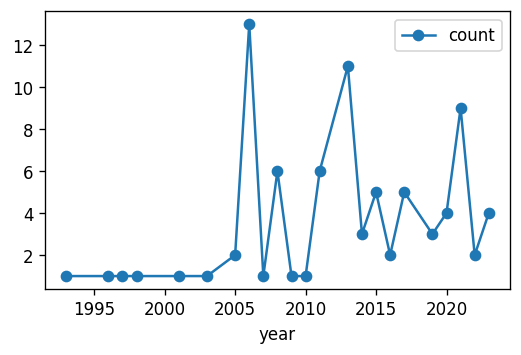

In [ ]:
# let's plot the number of structures per year
structures_per_year.plot(x="year", y="count", style="o-")

In [ ]:
# let's plot how the resolution changed over the years
pdbs = pdbs.sort_values(["year"], ascending=True, na_position="last")
pdbs[["date", "year", "resolution"]].head(10)

,date,year,resolution
0,1993-07-19 00:00:00+00:00,1993,NaN
3,1996-11-17 00:00:00+00:00,1996,2.50
1,1997-10-03 00:00:00+00:00,1997,NaN
36,1998-04-28 00:00:00+00:00,1998,1.65
83,2001-08-23 00:00:00+00:00,2001,NaN
37,2003-03-06 00:00:00+00:00,2003,3.42
4,2005-11-23 00:00:00+00:00,2005,1.91
2,2005-06-14 00:00:00+00:00,2005,NaN
5,2006-02-16 00:00:00+00:00,2006,2.00
47,2006-08-09 00:00:00+00:00,2006,1.70


<Axes: xlabel='year'>

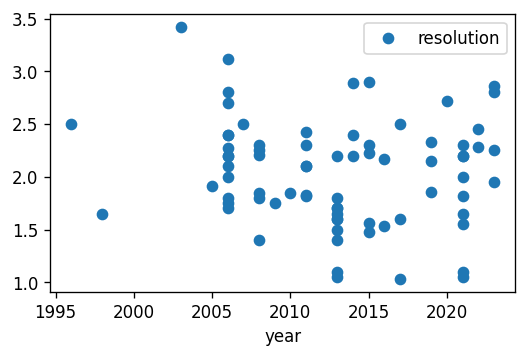

In [ ]:
pdbs.plot(x="year", y="resolution", style="o")

In [ ]:
# let's observe the type of methods used to obtain the structures
pdbs["method"].unique()

array(['SOLUTION NMR', 'X-RAY DIFFRACTION'], dtype=object)

In [ ]:
pdbs[pdbs.method == "X-RAY DIFFRACTION"].head()

,pdb_id,desc,title,method,date,num_atoms,resolution,rwork,rfree,year
3,2ABL,None,SH3-SH2 DOMAIN FRAGMENT OF HUMAN BCR-ABL TYROS...,X-RAY DIFFRACTION,1996-11-17 00:00:00+00:00,1321,2.50,0.183,0.270,1996
36,1BBZ,None,CRYSTAL STRUCTURE OF THE ABL-SH3 DOMAIN COMPLE...,X-RAY DIFFRACTION,1998-04-28 00:00:00+00:00,2415,1.65,0.205,0.266,1998
37,1OPL,None,Structural basis for the auto-inhibition of c-...,X-RAY DIFFRACTION,2003-03-06 00:00:00+00:00,6655,3.42,0.306,0.315,2003
4,2F4J,None,Structure of the Kinase Domain of an Imatinib-...,X-RAY DIFFRACTION,2005-11-23 00:00:00+00:00,2572,1.91,0.207,0.239,2005
5,2G2H,None,A Src-like Inactive Conformation in the Abl Ty...,X-RAY DIFFRACTION,2006-02-16 00:00:00+00:00,4889,2.00,0.193,0.213,2006


In [ ]:
pdbs[pdbs.method == "X-RAY DIFFRACTION"].head().resolution

,resolution
3,2.50
36,1.65
37,3.42
4,1.91
5,2.00


array([[<Axes: title={'center': 'resolution'}>]], dtype=object)

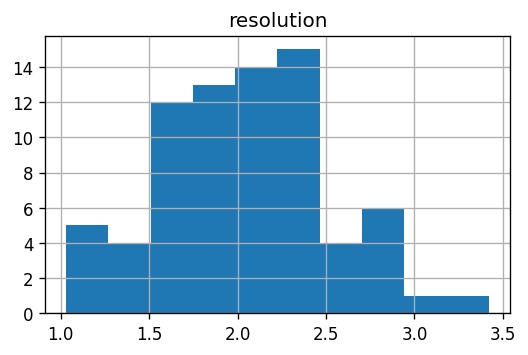

In [ ]:
pdbs.hist(column="resolution")

<img src="https://biopandas.github.io/biopandas/img/logos/logo_size_1.png" width="200" align="left"/>

## biopandas

[BioPandas](https://biopandas.github.io/biopandas/) simplifies the handling of protein structure files, such as PDB files, for computational biologists. It utilizes pandas DataFrames, widely used in data science, to work with biological macromolecule structures from PDB and MOL2 files in structural biology.

We will use it to extract the structure with the lowest resolution

In [ ]:
from biopandas.pdb import PandasPdb
# The following warning is a biopandas issue that will be fixed in the next release

/usr/local/lib/python3.10/dist-packages/biopandas/pdb/pandas_pdb.py:27: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  pd_version = LooseVersion(pd.__version__)


In [ ]:
pdbs["resolution"].min()

1.03

In [ ]:
pdbs["resolution"].idxmin()

17

In [ ]:
ID_min = pdbs["resolution"].idxmin()
pdbs.iloc[ID_min]


,44
pdb_id,2HYY
desc,None
title,Human Abl kinase domain in complex with imatin...
method,X-RAY DIFFRACTION
date,2006-08-08 00:00:00+00:00
num_atoms,8702
resolution,2.4
rwork,0.204
rfree,0.267
year,2006


In [ ]:
pdbs["pdb_id"].iloc[ID_min]

'2HYY'

In [ ]:
pdb_ID = pdbs["pdb_id"].iloc[ID_min]
ppdb = PandasPdb().fetch_pdb(pdb_ID)
ppdb

In [ ]:
ppdb.df["ATOM"].head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,TRP,,A,235,,...,2.281,3.258,18.672,1.0,89.25,,,N,NaN,793
1,ATOM,2,,CA,,TRP,,A,235,,...,3.704,3.708,18.689,1.0,88.99,,,C,NaN,794
2,ATOM,3,,C,,TRP,,A,235,,...,4.547,2.863,19.637,1.0,89.58,,,C,NaN,795
3,ATOM,4,,O,,TRP,,A,235,,...,5.780,2.841,19.526,1.0,89.50,,,O,NaN,796
4,ATOM,5,,CB,,TRP,,A,235,,...,3.800,5.202,19.053,1.0,88.09,,,C,NaN,797


<Axes: ylabel='Frequency'>

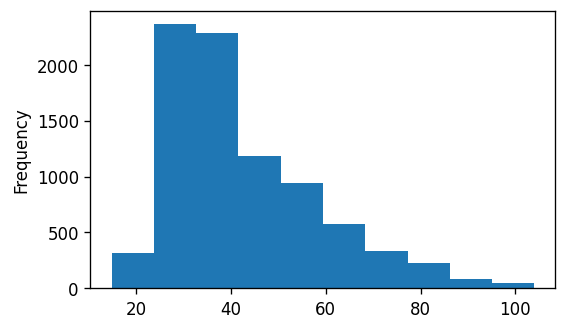

In [ ]:
ppdb.df["ATOM"]["b_factor"].plot(kind="hist")

<Axes: >

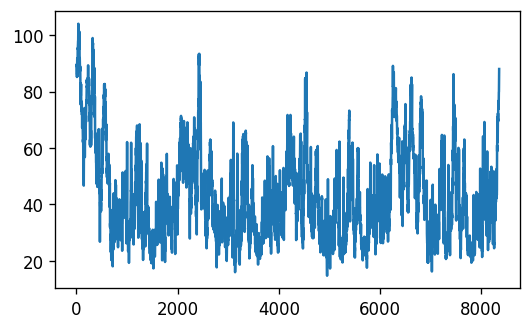

In [ ]:
ppdb.df["ATOM"]["b_factor"].plot(kind="line")

In [ ]:
ppdb.df["ATOM"].x_coord[0]

2.281

In [ ]:
def get_coord(pdb: PandasPdb, at: int) -> np.array:
    """Get the coordinates of an atom."""
    r = []
    for coord in ("x_coord", "y_coord", "z_coord"):
        r.append(pdb.df["ATOM"][coord][at])
    return np.array(r)


def calc_dist(pdb: PandasPdb, at1: int, at2: int) -> tuple[float, float]:
    """Calculate the distance between two atoms."""
    r1, r2 = get_coord(pdb, at1), get_coord(pdb, at2)
    r = r1 - r2
    d = math.sqrt(sum(r**2))
    d_alternative = np.linalg.norm(r)
    return d, d_alternative


calc_dist(ppdb, 0, 1)

(1.4925541866210421, 1.4925541866210421)

In [ ]:
# help(ppdb)
# execute to see what other function are available

In [ ]:
get_coord(ppdb, 0)
# ppdb.distance()

array([ 2.281,  3.258, 18.672])

In [ ]:
ppdb.distance(get_coord(ppdb, 0)).head()

,0
0,0.000000
1,1.492554
2,2.494395
3,3.625770
4,2.496329


## py3Dmol

For fast visualization of protein structures you can use py3Dmol.
py3Dmol is a wrapper around the 3Dmol.js JavaScript library.

In [46]:
import py3Dmol

view = py3Dmol.view(query="pdb:4XEY")
view.setStyle({"cartoon": {"color": "spectrum"}})
view.zoomTo()
view.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Exercises

1. Task 01: Perform a PDB query on a protein of choice (e.g. from a uniprot ID or by textual input query) and retrieve the data from the PDB database - note to use a query that will lead to some tens or hundreds of structures
2. Task 02: How many structures have you retrieved and how many of them are X-ray and how many NMR?
3. Task 03: Sort the structures by the resolution
4. Task 04: Determine the structure with the lowest and highest resolution.
5. Task 05: Visualize the structure with the lowest resolution using py3Dmol.



# Space for the Exercises

Rules for the exercises:
- Provide your solutions below this cell.
- Please, do NOT copy-paste code from the previous cells. (You are free to use the methods and functions defined above.)
- You are free to create your own methods.

### Task 01

In [14]:

# prepare search parameters using the uniprot ID of
# https://www.rcsb.org/structure/6ZBY


search_dict = {
    "query": {
        "type": "terminal",
        "label": "full_text",
        "service": "full_text",
        "parameters": {"value": "P06710"},
    },
    "return_type": "entry",
    "request_options": {
        "paginate": {"start": 0, "rows": 10000},
        "results_content_type": ["experimental"],
        "sort": [{"sort_by": "score", "direction": "desc"}],
        "scoring_strategy": "combined",
    },
}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# performing the search
response = requests.get(
    "https://search.rcsb.org/rcsbsearch/v2/query?json=" + json.dumps(search_dict)
)
data = response.json()
# printing the keys of the retreived dictionary
data.keys()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(26, 26)

### Task 02

In [16]:

# showing the total number of hits (how does this compare to the search performed on the website directly?)
data["total_count"], len(data["result_set"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(26, 26)

In [17]:
def extract_pdb_ids(search_result: dict) -> list:
    """Extracts the PDB IDs from the search result."""
    pdb_IDs = []
    for entry in search_result["result_set"]:
        pdb_IDs.append(entry["identifier"])
    return pdb_IDs


found_pdb_ids = extract_pdb_ids(data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# well, it is a good code, so let's reuse it...
def extract_interesting_info(pdb_info: dict) -> dict:
    """Extracts interesting information from the PDB info."""
    info = {
        "pdb_id": pdb_info["rcsb_id"],
        "desc": pdb_info["struct"].get("pdbx_descriptor"),
        "title": pdb_info["struct"]["title"],
        "method": pdb_info["exptl"][0]["method"],
        "date": pdb_info["rcsb_accession_info"]["deposit_date"],
        "num_atoms": pdb_info["rcsb_entry_info"]["deposited_atom_count"],
        "resolution": None,
        "rwork": None,
        "rfree": None,
    }

    # only for X-ray
    try:
        xray_info = {
            "resolution": pdb_info["refine"][0]["ls_dres_high"],
            "rwork": pdb_info["refine"][0]["ls_rfactor_rwork"],
            "rfree": pdb_info["refine"][0]["ls_rfactor_rfree"],
        }
        info.update(xray_info)
    except Exception as e:
        # print(f"Error: {e}")
        pass

    return (
        info  # pdb_id, desc, title, method, date, num_atoms, resolution, rwork, rfree
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# let’s collect data for all retrieved pdb codes
pdb_data = []
for pdb_id in tqdm(found_pdb_ids):
    pdb_data.append(extract_interesting_info(pypdb.get_info(pdb_id)))



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 26/26 [00:01<00:00, 14.20it/s]


In [39]:
# now we store this data in a pandas dataframe
pdbs = pd.DataFrame(pdb_data)
pdbs



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pdb_id,desc,title,method,date,num_atoms,resolution,rwork,rfree
0,2AYA,None,Solution Structure of the C-Terminal 14 kDa Do...,SOLUTION NMR,2005-09-07T00:00:00+0000,1007,NaN,NaN,NaN
1,1NJG,None,Nucleotide-free form of an Isolated E. coli Cl...,X-RAY DIFFRACTION,2002-12-30T00:00:00+0000,3862,2.200,0.2380,0.2680
2,1NJF,None,Nucleotide bound form of an isolated E. coli c...,X-RAY DIFFRACTION,2002-12-30T00:00:00+0000,7862,2.300,0.2100,0.2480
3,1JR3,None,Crystal Structure of the Processivity Clamp Lo...,X-RAY DIFFRACTION,2001-08-10T00:00:00+0000,13845,2.700,0.2676,0.3043
4,8GJ3,None,E. coli clamp loader on primed template DNA,ELECTRON MICROSCOPY,2023-03-14T00:00:00+0000,14894,NaN,NaN,NaN
5,8VAM,None,Structure of the E. coli clamp loader bound to...,ELECTRON MICROSCOPY,2023-12-11T00:00:00+0000,18771,NaN,NaN,NaN
6,8VAN,None,Structure of the E. coli clamp loader bound to...,ELECTRON MICROSCOPY,2023-12-11T00:00:00+0000,19433,NaN,NaN,NaN
7,8VAP,None,Structure of the E. coli clamp loader bound to...,ELECTRON MICROSCOPY,2023-12-11T00:00:00+0000,18613,NaN,NaN,NaN
8,1XXI,None,ADP Bound E. coli Clamp Loader Complex,X-RAY DIFFRACTION,2004-11-05T00:00:00+0000,27688,4.100,0.3660,0.3690
9,3GLF,None,Crystal Structure of the Ecoli Clamp Loader Bo...,X-RAY DIFFRACTION,2009-03-12T00:00:00+0000,28758,3.388,0.2214,0.2604


In [36]:
pdbs.loc[pdbs['method'] == "X-RAY DIFFRACTION"]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pdb_id,desc,title,method,date,num_atoms,resolution,rwork,rfree
1,1NJG,None,Nucleotide-free form of an Isolated E. coli Cl...,X-RAY DIFFRACTION,2002-12-30T00:00:00+0000,3862,2.200,0.2380,0.2680
2,1NJF,None,Nucleotide bound form of an isolated E. coli c...,X-RAY DIFFRACTION,2002-12-30T00:00:00+0000,7862,2.300,0.2100,0.2480
3,1JR3,None,Crystal Structure of the Processivity Clamp Lo...,X-RAY DIFFRACTION,2001-08-10T00:00:00+0000,13845,2.700,0.2676,0.3043
8,1XXI,None,ADP Bound E. coli Clamp Loader Complex,X-RAY DIFFRACTION,2004-11-05T00:00:00+0000,27688,4.100,0.3660,0.3690
9,3GLF,None,Crystal Structure of the Ecoli Clamp Loader Bo...,X-RAY DIFFRACTION,2009-03-12T00:00:00+0000,28758,3.388,0.2214,0.2604
10,3GLG,None,Crystal Structure of a Mutant (gammaT157A) E. ...,X-RAY DIFFRACTION,2009-03-12T00:00:00+0000,28746,3.250,0.2240,0.2630
18,1XXH,None,ATPgS Bound E. Coli Clamp Loader Complex,X-RAY DIFFRACTION,2004-11-05T00:00:00+0000,27736,3.450,0.3150,0.3500
19,3GLH,None,Crystal Structure of the E. coli clamp loader ...,X-RAY DIFFRACTION,2009-03-12T00:00:00+0000,41322,3.891,0.3593,0.3614
20,3GLI,None,Crystal Structure of the E. coli clamp loader ...,X-RAY DIFFRACTION,2009-03-12T00:00:00+0000,29139,3.500,0.2216,0.2573


In [35]:
len(pdbs.loc[pdbs['method'] == "X-RAY DIFFRACTION"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


9

In [37]:
pdbs.loc[pdbs['method'] == "SOLUTION NMR"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pdb_id,desc,title,method,date,num_atoms,resolution,rwork,rfree
0,2AYA,None,Solution Structure of the C-Terminal 14 kDa Do...,SOLUTION NMR,2005-09-07T00:00:00+0000,1007,NaN,NaN,NaN


In [38]:
len(pdbs.loc[pdbs['method'] == "SOLUTION NMR"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1

### Task 03

In [41]:
pdbs.sort_values(by = ['resolution'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pdb_id,desc,title,method,date,num_atoms,resolution,rwork,rfree
1,1NJG,None,Nucleotide-free form of an Isolated E. coli Cl...,X-RAY DIFFRACTION,2002-12-30T00:00:00+0000,3862,2.200,0.2380,0.2680
2,1NJF,None,Nucleotide bound form of an isolated E. coli c...,X-RAY DIFFRACTION,2002-12-30T00:00:00+0000,7862,2.300,0.2100,0.2480
3,1JR3,None,Crystal Structure of the Processivity Clamp Lo...,X-RAY DIFFRACTION,2001-08-10T00:00:00+0000,13845,2.700,0.2676,0.3043
10,3GLG,None,Crystal Structure of a Mutant (gammaT157A) E. ...,X-RAY DIFFRACTION,2009-03-12T00:00:00+0000,28746,3.250,0.2240,0.2630
9,3GLF,None,Crystal Structure of the Ecoli Clamp Loader Bo...,X-RAY DIFFRACTION,2009-03-12T00:00:00+0000,28758,3.388,0.2214,0.2604
18,1XXH,None,ATPgS Bound E. Coli Clamp Loader Complex,X-RAY DIFFRACTION,2004-11-05T00:00:00+0000,27736,3.450,0.3150,0.3500
20,3GLI,None,Crystal Structure of the E. coli clamp loader ...,X-RAY DIFFRACTION,2009-03-12T00:00:00+0000,29139,3.500,0.2216,0.2573
19,3GLH,None,Crystal Structure of the E. coli clamp loader ...,X-RAY DIFFRACTION,2009-03-12T00:00:00+0000,41322,3.891,0.3593,0.3614
8,1XXI,None,ADP Bound E. coli Clamp Loader Complex,X-RAY DIFFRACTION,2004-11-05T00:00:00+0000,27688,4.100,0.3660,0.3690
0,2AYA,None,Solution Structure of the C-Terminal 14 kDa Do...,SOLUTION NMR,2005-09-07T00:00:00+0000,1007,NaN,NaN,NaN


### Task 04

In [45]:
pdbs.loc[pdbs['resolution'].idxmin()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,1
pdb_id,1NJG
desc,None
title,Nucleotide-free form of an Isolated E. coli Cl...
method,X-RAY DIFFRACTION
date,2002-12-30T00:00:00+0000
num_atoms,3862
resolution,2.2
rwork,0.238
rfree,0.268


In [44]:
pdbs.loc[pdbs['resolution'].idxmax()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,8
pdb_id,1XXI
desc,None
title,ADP Bound E. coli Clamp Loader Complex
method,X-RAY DIFFRACTION
date,2004-11-05T00:00:00+0000
num_atoms,27688
resolution,4.1
rwork,0.366
rfree,0.369


### Task 05

In [47]:
import py3Dmol

view = py3Dmol.view(query="pdb:1XXI")
view.setStyle({"cartoon": {"color": "spectrum"}})
view.zoomTo()
view.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


## For the project

For this project, you will select a protein of interest and perform a detailed analysis.
This protein will be your research subject. In the upcoming exercises, you will model, simulate, and analyze the interactions between your chosen protein and other molecules.
It's important to select your protein early to facilitate better project planning.

### Project Tasks

1. **Retrieve protein data** (5 points):

  - After choosing the protein of interest, retrieve the Uniprot ID and search in the PDB database using this exercise as a template.

2. **Analyze available structures** (5 points):

  - Determine the number of structures and the number of X-ray and NMR structures.
  - Identify how many structures were determined by X-ray crystallography and how many by NMR.

3. **Select the ideal structure** (5 points):

  - Determine the ideal structure for your project based on the resolution, method, and date of the structure. Choose the structure with the lowest resolution, the most complete one, and the most recent one. You can always check the literature for a more decision. Justify your choice.

4. **Visualize the Protein Structure** (10 points):

  - Generate images with the following characteristics (Use any software you prefer, I recommend you PyMol):

    1. Secondary Structure Coloring:
      - Display the structure in cartoon representation and color it by secondary structure.

    2. Domain or Motif Coloring:
      - Display the structure in cartoon representation.
      - Color it by domains or motifs. (Information obtained in the Uniprot database, PDB database, or literature)

    3. B-factor Coloring (X-ray) or NMR bundle visualization:
      - For the X-ray structure, display the structure in cartoon representation and color it by b-factor.
      - For the NMR structure, visualize the bundle. (An NMR bundle is a set of structures that satisfy experimental data. This set of structures is reported within one PDB file.)

    4. Ligand or Heteroatom Analysis (if present):
      - Zoom to the ligand or heteroatoms.
      - Visualize the amino acids involved in the interaction.


  - Rules for images:
    - The images must be clear and informative.
    - The images should be rendered in a resolution of at least 800x600 pixels.
    - The images background must be white or transparent.
    - The images should not contain the Software Interface (e.g., PyMol interface).
    - Use preferably Ray Tracing for image rendering.
